In [1]:
import pandas as pd
import statsmodels.api as sm 
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('fundamentals.csv')
df

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,curcd,fyr,apdedate,...,txndbl,txndbr,txp,txt,xt,costat,prcc_c,prcc_f,ggroup,sic
0,1018,06/30/1980,1980,INDL,C,D,STD,USD,6,NaN,...,NaN,NaN,0.003,-0.018,NaN,I,3.000,3.500,2520,3861
1,1018,06/30/1981,1981,INDL,C,D,STD,USD,6,NaN,...,NaN,NaN,0.010,0.010,NaN,I,3.000,4.625,2520,3861
2,1018,06/30/1982,1982,INDL,C,D,STD,USD,6,NaN,...,NaN,NaN,0.020,0.030,NaN,I,0.625,1.812,2520,3861
3,1018,06/30/1983,1983,INDL,C,D,STD,USD,6,NaN,...,NaN,NaN,0.013,0.012,NaN,I,1.375,1.375,2520,3861
4,1018,06/30/1984,1984,INDL,C,D,STD,USD,6,NaN,...,NaN,NaN,0.000,0.000,NaN,I,1.625,1.625,2520,3861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14807,271841,12/31/2016,2016,INDL,C,D,STD,USD,12,12/31/2016,...,85.163,0.0,15.936,30.764,NaN,A,1.110,1.110,2520,1520
14808,271841,12/31/2017,2017,INDL,C,D,STD,USD,12,12/31/2017,...,41.349,0.0,14.018,-6.974,NaN,A,12.620,12.620,2520,1520
14809,271841,12/31/2018,2018,INDL,C,D,STD,USD,12,12/31/2018,...,34.300,0.0,14.795,-5.618,NaN,A,8.270,8.270,2520,1520
14810,271841,12/31/2019,2019,INDL,C,D,STD,USD,12,12/31/2019,...,20.823,0.0,17.382,-8.776,NaN,A,4.311,4.311,2520,1520


Methods to do this analysis
1. Use data from previous year (all companies) and make a regression model to predict the earnings for next 
year for all companies. 
    Problem is that test set = training set
2. Fit a regression to previous year's data for a company only and use that to predict the company's earnings for
the next year.
    Problem is that data is only trained on company. How do we split between training and test?
3. Fit a regression to all data from all companies that comes before the current date. Train model on that data and
predict on next year's data.
    Problem is that we dont know how to run a panel regression?
4. Follow the same process as CAPM. (can we do this with multiple betas?)
    Regress eps on ni for each company for first few years of data
    Regress eps on betas from the first regression for the next year. 

In [4]:
print(df.columns)
len(df.columns)

Index(['gvkey', 'datadate', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt',
       'curcd', 'fyr', 'apdedate', 'fdate', 'act', 'ap', 'at', 'capx', 'ch',
       'csho', 'dp', 'dvt', 'ebit', 'ebitda', 'glp', 'gp', 'invt', 'lt', 'ni',
       'oiadp', 'oibdp', 'opeps', 'opincar', 'opiti', 'rect', 'txndba',
       'txndbl', 'txndbr', 'txp', 'txt', 'xt', 'costat', 'prcc_c', 'prcc_f',
       'ggroup', 'sic'],
      dtype='object')


43

In [5]:
#dropping columns with only one value in all the rows
for i in df.columns:
    if(len(df[i].unique()) == 1):
        df.drop(i, axis=1,inplace=True)

In [6]:
print(df.columns)
len(df.columns)

Index(['gvkey', 'datadate', 'fyear', 'fyr', 'apdedate', 'fdate', 'act', 'ap',
       'at', 'capx', 'ch', 'csho', 'dp', 'dvt', 'ebit', 'ebitda', 'glp', 'gp',
       'invt', 'lt', 'ni', 'oiadp', 'oibdp', 'opeps', 'rect', 'txndba',
       'txndbl', 'txndbr', 'txp', 'txt', 'costat', 'prcc_c', 'prcc_f', 'sic'],
      dtype='object')


34

In [7]:
df.isna().sum()

gvkey           0
datadate        0
fyear           0
fyr             0
apdedate    11044
fdate       11889
act          2389
ap            856
at            838
capx         1150
ch           1897
csho          982
dp            981
dvt           966
ebit          897
ebitda        975
glp         14276
gp            896
invt          904
lt            854
ni            892
oiadp         897
oibdp         975
opeps        4732
rect         1366
txndba      11248
txndbl      11249
txndbr      11149
txp           996
txt           895
costat          0
prcc_c       2433
prcc_f       2460
sic             0
dtype: int64

In [8]:
#dropping all rows with missing values for NI and common shares outstanding
df.dropna(subset=['ni','csho'],inplace=True)

#columns necessary for the analysis
cols = ['gvkey','fyear','at','ebit','oiadp','gp','txt','csho','ni']

data  = df[cols]
#number of companies in the dataset
len(data.gvkey.unique())

1141

In [9]:
#some companies were only active for 1 year. 
data['gvkey'].value_counts()

7116      43
6497      42
8219      42
8823      42
7179      42
          ..
21702      1
36826      1
21105      1
126894     1
30253      1
Name: gvkey, Length: 1141, dtype: int64

In [10]:
#eps is our target variable. 
data = data[data['csho'] > 0]
data['eps'] = df['ni']/df['csho']

In [11]:
#shifting the NI column to remove look ahead bias (checked)
eps = data.groupby('gvkey')['eps'].shift(-1)
data['eps'] = eps
data.dropna(inplace=True)
data

,gvkey,fyear,at,ebit,oiadp,gp,txt,csho,ni,eps
0,1018,1980,7.368,-4.563,-4.563,0.030,-0.018,4.946,-5.703,-0.200185
1,1018,1981,4.033,0.246,0.246,2.760,0.010,5.420,-1.085,0.023972
2,1018,1982,3.747,0.708,0.708,2.881,0.030,5.715,0.137,0.014523
3,1018,1983,3.936,0.731,0.731,2.590,0.012,5.715,0.083,-0.174848
4,1018,1984,5.059,0.686,0.686,2.864,0.000,6.560,-1.147,-0.073556
...,...,...,...,...,...,...,...,...,...,...
14806,271841,2015,1707.456,29.368,29.368,158.316,1.814,183.741,18.804,-1.965766
14807,271841,2016,1601.527,-129.176,-129.176,-34.894,30.764,181.953,-357.677,-18.935208
14808,271841,2017,868.977,-159.837,-159.837,-63.382,-6.974,13.551,-256.591,-5.447818
14809,271841,2018,652.563,-32.363,-32.363,29.633,-5.618,19.892,-108.368,-0.110718


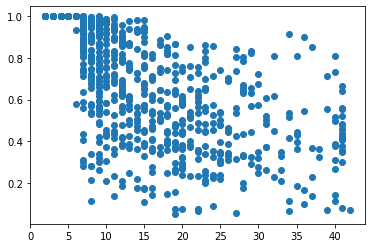

In [12]:
#Method 2 (split into train and test - not enough data)
rsq = []
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    rsq.append(result.rsquared)
    return result.params


#This is what you need
data.groupby('gvkey').apply(regress, 'eps', ['at','ebit','oiadp','gp','txt','ni'])

#see how many rows per gvkey are there, in order of the groupedby df above
gvkey = data.gvkey.unique()
val_count_gvkey = []
for i in gvkey:
    val_count_gvkey.append(len(data[data['gvkey']==i]))

#rsquared is all over the place
plt.scatter(val_count_gvkey, rsq)

In [13]:
#find number of companies with more than x years of data
x = 5
print('Number of companies with more than',x, 'years of data:  ', sum(data['gvkey'].value_counts() >= 8))
print('Total number of companies in the dataset:  ', len(data['gvkey'].unique()))

Number of companies with more than 5 years of data:   578
Total number of companies in the dataset:   1103


In [99]:
start = 1980
end = 2022
for i in range(start, end):
    if(i)

,gvkey,fyear,at,ebit,oiadp,gp,txt,csho,ni,eps
0,1018,1980,7.368,-4.563,-4.563,0.030,-0.018,4.946,-5.703,-0.200185
1,1018,1981,4.033,0.246,0.246,2.760,0.010,5.420,-1.085,0.023972
2,1018,1982,3.747,0.708,0.708,2.881,0.030,5.715,0.137,0.014523
3,1018,1983,3.936,0.731,0.731,2.590,0.012,5.715,0.083,-0.174848
4,1018,1984,5.059,0.686,0.686,2.864,0.000,6.560,-1.147,-0.073556
...,...,...,...,...,...,...,...,...,...,...
14806,271841,2015,1707.456,29.368,29.368,158.316,1.814,183.741,18.804,-1.965766
14807,271841,2016,1601.527,-129.176,-129.176,-34.894,30.764,181.953,-357.677,-18.935208
14808,271841,2017,868.977,-159.837,-159.837,-63.382,-6.974,13.551,-256.591,-5.447818
14809,271841,2018,652.563,-32.363,-32.363,29.633,-5.618,19.892,-108.368,-0.110718


In [14]:
#splitting into training and testing set
ind = data.groupby(['gvkey']).tail(2).index
test = data.filter(items = ind , axis=0)
train = data.drop(data.groupby(['gvkey']).tail(2).index)